# **Used Car Price Prediction**

### **Problem Description**

The price of a used car is a critical factor in the automotive market, reflecting a vehicle's value based on its condition, history, features, and brand reputation. Predicting market prices accurately helps sellers set competitive rates, allows buyers to negotiate fair deals, and allows dealerships to manage their inventory.

The dataset was taken from Kaggle: https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset.

The purpose of this project is to simulate the process of predicting the selling price of used cars using multiple ML regression techniques and comparing their performance on the analyzed data.


### **Data Description**

The dataset was sourced from Kaggle:

The dataset consists of the following columns:
* brand: The manufacturer of the car (e.g., Ford, Toyota).

* model: The specific model name (e.g., F-150, Camry).

* model_year: The manufacturing year of the vehicle.

* milage: The total distance driven by the car (in miles).

* fuel_type: The type of fuel used (e.g., Gasoline, Hybrid, Diesel).

* engine: Technical description of the engine (e.g., horsepower, displacement, cylinder count).

* transmission: The type of transmission (e.g., Automatic, CVT, Manual).

* ext_col: The exterior color of the car.

* int_col: The interior color of the car.

* accident: Reported accident history (e.g., "At least 1 accident or damage reported").

* clean_title: Indicator of whether the car has a clean title status.

* price: The listed selling price of the car (target variable).

## Import Dependencies

In [ ]:
!pip install xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

### Data import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/used_cars.csv')

### Data cleaning

In [ ]:
# before cleaning
print(df[['price', 'milage']].head())

     price      milage
0  $10,300  51,000 mi.
1  $38,005  34,742 mi.
2  $54,598  22,372 mi.
3  $15,500  88,900 mi.
4  $34,999   9,835 mi.


In [ ]:
df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df['milage'] = df['milage'].astype(str)
df['milage'] = df['milage'].str.replace(' mi.', '')
df['milage'] = df['milage'].str.replace(',', '')
df['milage'] = pd.to_numeric(df['milage'], errors='coerce')

df['fuel_type'] = df['fuel_type'].fillna('Unknown')
df['accident'] = df['accident'].fillna('Unknown')
df['clean_title'] = df['clean_title'].fillna('Unknown')
df = df.dropna(subset=['price'])

In [ ]:
# after cleaning
print(df[['price', 'milage']].head())

   price  milage
0  10300   51000
1  38005   34742
2  54598   22372
3  15500   88900
4  34999    9835


### Feature Engineering

In [ ]:
# We need to get Horsepower from the Engine text
def get_horsepower(text):
    text = str(text)

    if 'HP' in text:
        match = re.search(r'(\d+\.?\d*)HP', text)
        if match:
            return float(match.group(1))

    return 0.0

In [ ]:
df['horsepower'] = df['engine'].apply(get_horsepower)

# if horsepower = 0, replace it with the median value
median_hp = df['horsepower'].median()
df['horsepower'] = df['horsepower'].replace(0.0, median_hp)

df[['engine', 'horsepower']].head()

,engine,horsepower
0,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,300.0
1,3.8L V6 24V GDI DOHC,285.0
2,3.5 Liter DOHC,285.0
3,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,354.0
4,2.0L I4 16V GDI DOHC Turbo,285.0


## Exploratory Data Analysis (EDA)



In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   object 
 1   model         4009 non-null   object 
 2   model_year    4009 non-null   int64  
 3   milage        4009 non-null   int64  
 4   fuel_type     4009 non-null   object 
 5   engine        4009 non-null   object 
 6   transmission  4009 non-null   object 
 7   ext_col       4009 non-null   object 
 8   int_col       4009 non-null   object 
 9   accident      4009 non-null   object 
 10  clean_title   4009 non-null   object 
 11  price         4009 non-null   int64  
 12  horsepower    4009 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 407.3+ KB
None


In [27]:
print(df.describe())

        model_year         milage         price   horsepower
count  4009.000000    4009.000000  4.009000e+03  4009.000000
mean   2015.515590   64717.551010  4.455319e+04   322.692193
std       6.104816   52296.599459  7.871064e+04   110.871764
min    1974.000000     100.000000  2.000000e+03    70.000000
25%    2012.000000   23044.000000  1.720000e+04   268.000000
50%    2017.000000   52775.000000  3.100000e+04   285.000000
75%    2020.000000   94100.000000  4.999000e+04   381.000000
max    2024.000000  405000.000000  2.954083e+06  1020.000000


In [26]:
print(df.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
horsepower      0
dtype: int64


Dataset Statistics
Total cars: 4009
Average Price: $ 44553.19
Median Price: $ 31000.0
Max Price: $ 2954083
Min Price: $ 2000


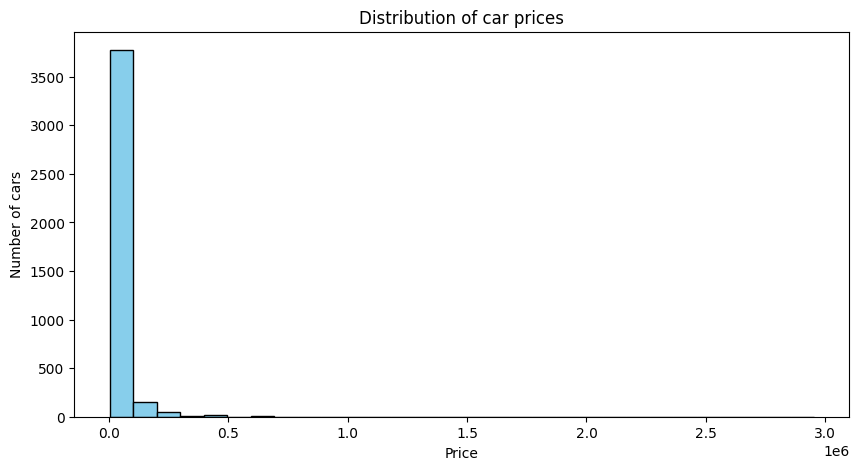

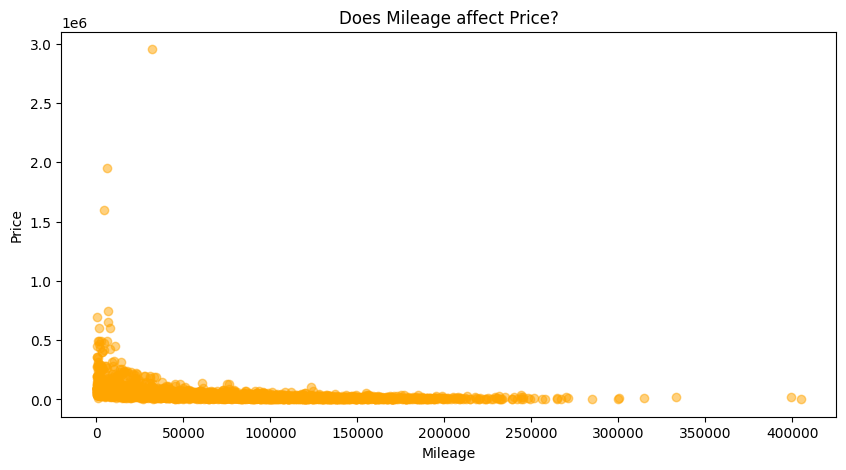

In [ ]:
print("Dataset Statistics")
print("Total cars:", len(df))
print("Average Price: $", round(df['price'].mean(), 2))
print("Median Price: $", round(df['price'].median(), 2))
print("Max Price: $", df['price'].max())
print("Min Price: $", df['price'].min())

plt.figure(figsize=(10, 5))
plt.hist(df['price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of car prices')
plt.xlabel('Price')
plt.ylabel('Number of cars')
plt.show()

# Price vs Mileage
plt.figure(figsize=(10, 5))
plt.scatter(df['milage'], df['price'], alpha=0.5, color='orange')
plt.title('Does Mileage affect Price?')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

As we see, most values are concentrated at one end + outliers as visible in Max value (2.9mln compared to the median 50% = 31,000). Let's apply Log Transformation to make the distribution more uniform (reduce skewness, make outliers less impactful and cap them).

#### Capping outliers

In [30]:
print("Original data shape:", df.shape)

# We remove the top 1% of most expensive cars to stabilize the model
price_limit = df['price'].quantile(0.99)
mileage_limit = df['milage'].quantile(0.99)

print(f"Capping prices above: {price_limit:,.0f}")
print(f"Capping mileage above: {mileage_limit:,.0f}")

df = df[(df['price'] < price_limit) & (df['milage'] < mileage_limit)]
print("Data shape after capping:", df.shape)

Original Data Shape: (4009, 13)
Capping prices above: 272,713
Capping mileage above: 222,428
Data Shape after Capping: (3927, 13)


#### Log Transformation

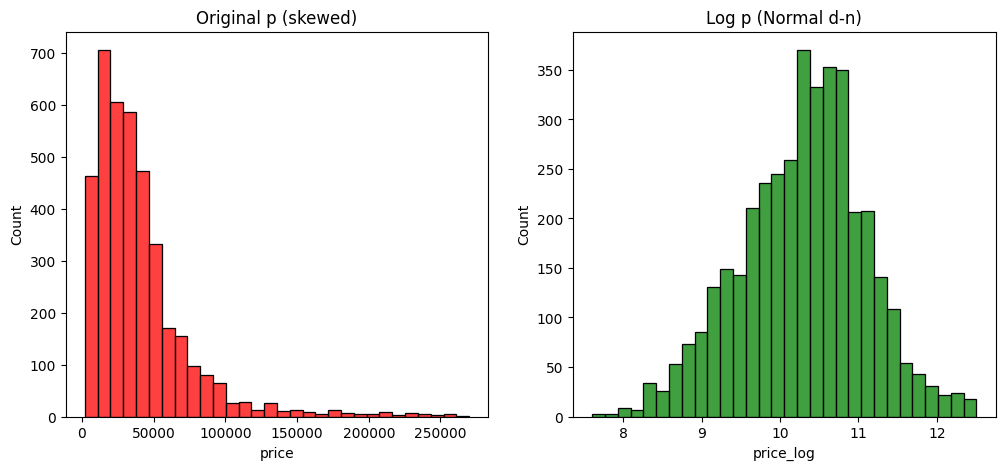

In [31]:
df['price_log'] = np.log1p(df['price'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=30, color='red')
plt.title('Original p (skewed)')

plt.subplot(1, 2, 2)
sns.histplot(df['price_log'], bins=30, color='green')
plt.title('Log p (Normal d-n)')
plt.show()

In [32]:
df['price'] = df['price_log']
df = df.drop(columns=['price_log'])

#### Analyze the patterns

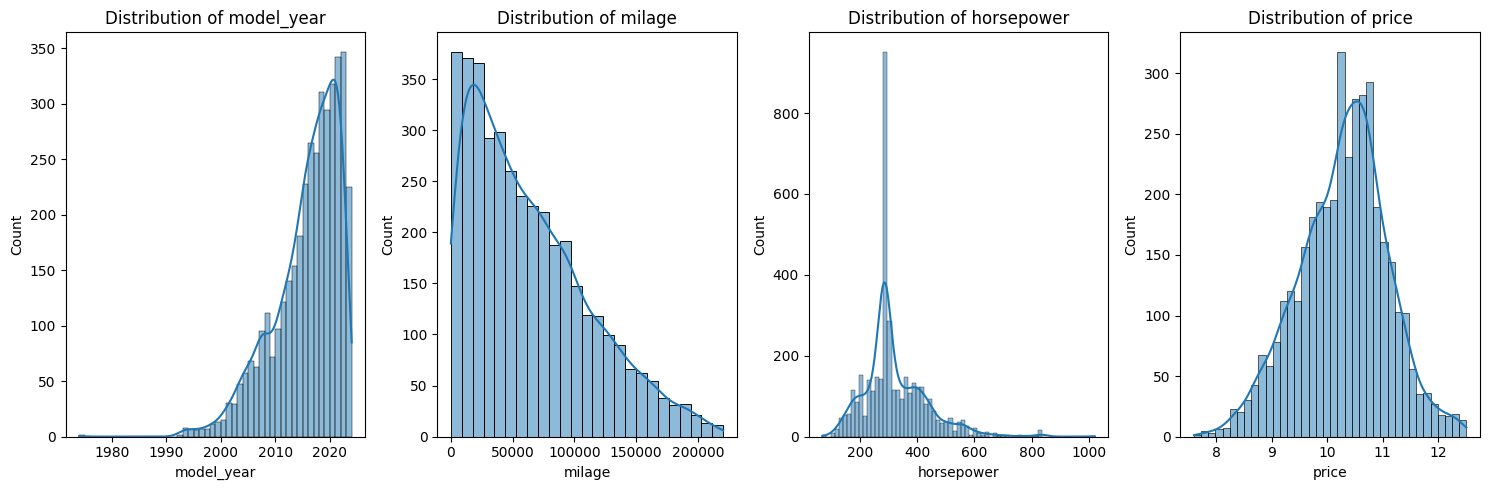

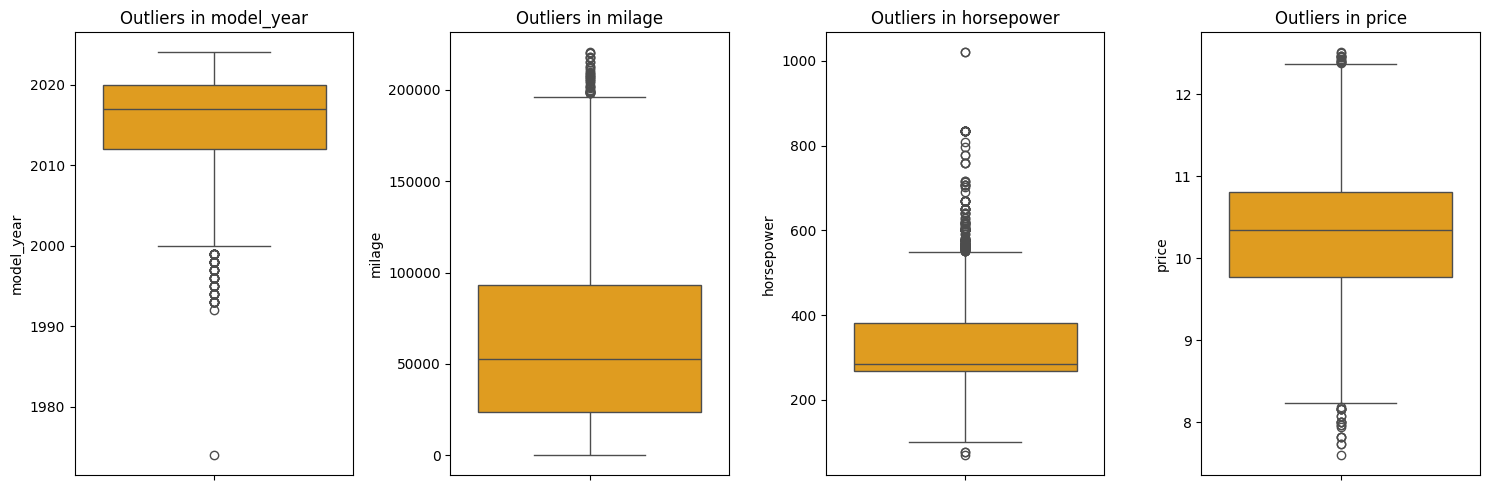

In [33]:
numeric_cols = ['model_year', 'milage', 'horsepower', 'price']

plt.figure(figsize=(15, 5))
for i, column in enumerate(numeric_cols):
    plt.subplot(1, 4, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, column in enumerate(numeric_cols):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[column], color='orange')
    plt.title(f'Outliers in {column}')
plt.tight_layout()
plt.show()

The visual analysis confirms that our Capping + Log Transformation successfully normalized our Target variable. Even though like Mileage and Year have their natural skewness, the outliers are now placed to a range that will not destabilize further models.

#### Encoding

In [ ]:
df_model = df.copy()

text_columns = ['brand', 'model', 'fuel_type', 'transmission',
                'ext_col', 'int_col', 'accident', 'clean_title', 'engine']

le = LabelEncoder()

for col in text_columns:
    df_model[col] = df_model[col].astype(str)
    df_model[col] = le.fit_transform(df_model[col])

X = df_model.drop('price', axis=1)
y = df_model['price']

In [ ]:
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("training shape:", X_train.shape)

training shape: (3207, 12)


### Models

#### CatBoost

Training CatBoost...
0:	learn: 50229.7717926	total: 10.2ms	remaining: 10.2s
100:	learn: 24114.5397714	total: 731ms	remaining: 6.51s
200:	learn: 18704.4502189	total: 1.61s	remaining: 6.4s
300:	learn: 15125.7341001	total: 2.59s	remaining: 6.03s
400:	learn: 12986.9690069	total: 3.69s	remaining: 5.51s
500:	learn: 11496.2485287	total: 4.62s	remaining: 4.6s
600:	learn: 10278.6337272	total: 5.29s	remaining: 3.51s
700:	learn: 9229.6849867	total: 5.51s	remaining: 2.35s
800:	learn: 8491.4689978	total: 5.73s	remaining: 1.42s
900:	learn: 7876.2603952	total: 5.95s	remaining: 654ms
999:	learn: 7375.9831010	total: 6.19s	remaining: 0us
Detected Dollar Data. No conversion needed.

Final Results:
RMSE (Error): $131,046.04
R2 Score:     0.1598


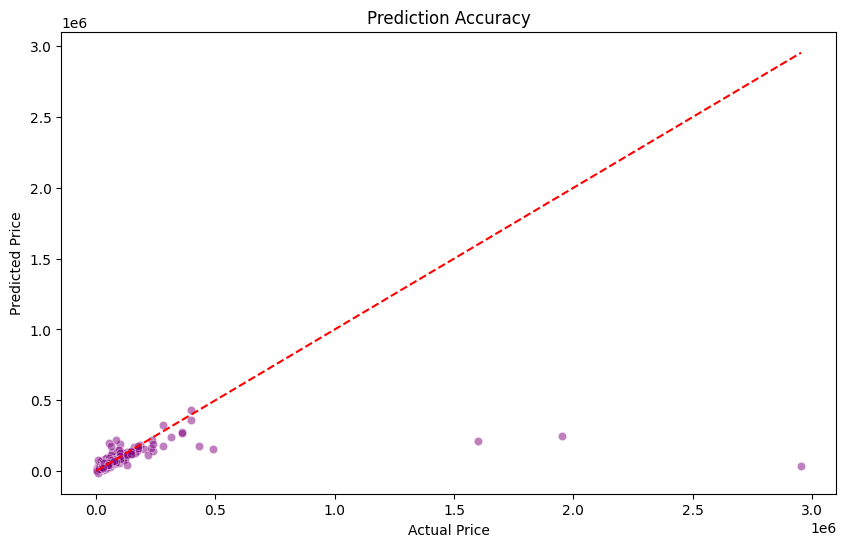

In [36]:
# --- MODELING: CatBoost (Crash-Proof Version) ---
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Train
print("Training CatBoost...")
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    verbose=500
)
model.fit(X_train, y_train)

# 2. Predict
predictions = model.predict(X_test)

# --- 3. THE SMART FIX ---
# Check if we need to convert back from Log scale
# If the max value in y_test is small (like 15), it's definitely Log scale.
# If the max value is big (like 30,000), it's already Dollars.

if y_test.max() < 100:
    print("Detected Log Data. Converting back to Dollars...")
    # Clip to prevent overflow (max value ~ $9 Million)
    predictions = np.clip(predictions, 0, 16)
    y_test_safe = np.clip(y_test, 0, 16)

    # Convert
    final_preds = np.expm1(predictions)
    final_actuals = np.expm1(y_test_safe)
else:
    print("Detected Dollar Data. No conversion needed.")
    final_preds = predictions
    final_actuals = y_test

# 4. Evaluate
rmse = np.sqrt(mean_squared_error(final_actuals, final_preds))
r2 = r2_score(final_actuals, final_preds)

print("\n" + "="*40)
print(f"Final Results:")
print(f"RMSE (Error): ${rmse:,.2f}")
print(f"R2 Score:     {r2:.4f}")
print("="*40)

# 5. Visual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_actuals, y=final_preds, alpha=0.5, color='purple')
plt.plot([final_actuals.min(), final_actuals.max()], [final_actuals.min(), final_actuals.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Prediction Accuracy')
plt.show()

In [35]:
# --- MODELING: CatBoost ---

# 1. Train the Model
print("Training CatBoost Model...")

# We use standard parameters (good for projects like this)
# 'verbose=100' means it will print an update every 100 steps
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    verbose=500
)

# Train on the 80% split
model.fit(X_train, y_train)

# 2. Predict on the Test Data (The 20% split)
# Remember: These predictions are in LOG scale because we trained on Log Price
# 2. Predict on the Test Data (The 20% split)
log_predictions = model.predict(X_test)

# --- SAFETY FIX START ---
# We force the predictions to stay within a realistic range
# Log 16 is about $9,000,000. Anything higher is an error.
log_predictions = np.clip(log_predictions, a_min=None, a_max=16)

# Check if y_test has any infinity (just in case)
y_test = np.nan_to_num(y_test)
# --- SAFETY FIX END ---

# 3. Convert Back to Real Dollars
predictions_dollars = np.expm1(log_predictions)
y_test_dollars = np.expm1(y_test)

# 4. Evaluate Performance (Now it should work)
rmse = np.sqrt(mean_squared_error(y_test_dollars, predictions_dollars))
r2 = r2_score(y_test_dollars, predictions_dollars)


print("\n" + "="*40)
print(f"Final Model Results:")
print(f"RMSE (Average Error): ${rmse:,.2f}")
print(f"R2 Score (Accuracy):  {r2:.4f}")
print("="*40)

# 5. Visual: Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_dollars, y=predictions_dollars, alpha=0.5, color='purple')

# Draw a red line showing perfect predictions
plt.plot([y_test_dollars.min(), y_test_dollars.max()],
         [y_test_dollars.min(), y_test_dollars.max()],
         'r--', lw=2)

plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('CatBoost: Prediction Accuracy (Real Dollars)')
plt.show()

Training CatBoost Model...
0:	learn: 50229.7717926	total: 3.28ms	remaining: 3.28s
500:	learn: 11496.2485287	total: 2.25s	remaining: 2.24s
999:	learn: 7375.9831010	total: 4.2s	remaining: 0us


ValueError: Input contains infinity or a value too large for dtype('float64').